# Signal Creation Pipeline

In [15]:
%load_ext autoreload
%autoreload 2

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from modules.signals import plot_realization, get_sentiment_score, compute_key_metrics, get_relative_strength_index, get_moving_average_crossover
from modules.data_utils import load_reddit_data, load_bitcoin_data
from modules.data_cleaning import preprocess_data
from modules.sentiment_analysis import get_roberta_checkpoint
from modules.btc_price_data_processing import add_performance_metrics
from modules.utils import set_pandas_display_options
set_pandas_display_options()

## Load and clean data

In [2]:
df = load_reddit_data()

## Sentiment Analysis

In [3]:
# get checkpoint
sentiment_roberta = get_roberta_checkpoint()

# merge sentiment
df = pd.merge(df, sentiment_roberta, how="left", on="submission")

## Relevance filtering

In [4]:
# LDA filter
topic_keywords = pd.read_csv("topic_keywords.csv")
trading_keywords = topic_keywords.loc[topic_keywords["Topic"]=="Topic 2", "Keyword"].values

com_filter = (df["num_comments"] > 100)
lda_filter = df["selftext"].str.lower().str.contains("|".join(trading_keywords))
print(df.shape)
df_lda = df.loc[lda_filter].copy() # filter on LDA topics
print(df_lda.shape)

(15582, 28)
(11048, 28)


## Sentiment Signal

In [6]:
lag = "1h"

df = get_sentiment_score(df, lag, True, True, alpha_name="alpha_sentiment")
df_lda = get_sentiment_score(df_lda, lag, True, False, alpha_name="alpha_sentiment")

## Merge baseline strategies

In [45]:
df = df_lda

In [46]:
from modules.signals import get_relative_strength_index
df_rsi = get_relative_strength_index(lower_cutoff=df["datetime"].min(), upper_cutoff=df["datetime"].max())

In [47]:
from modules.signals import get_moving_average_crossover
df_maco = get_moving_average_crossover(lower_cutoff=df["datetime"].min(), upper_cutoff=df["datetime"].max())

In [48]:
df = pd.merge_asof(df_rsi[["rsi_signal"]], df, on='datetime', direction='backward')
df = pd.merge_asof(df_maco[["maco_signal"]], df, on='datetime', direction='backward')

# Price prediction

In [49]:
plot_df = df.copy()
plot_df = add_performance_metrics(plot_df, [1])

(<Figure size 1200x600 with 1 Axes>,
 <Axes: title={'center': 'Cumulative Realized Performance'}, xlabel='Date', ylabel='Cumulative Performance'>)

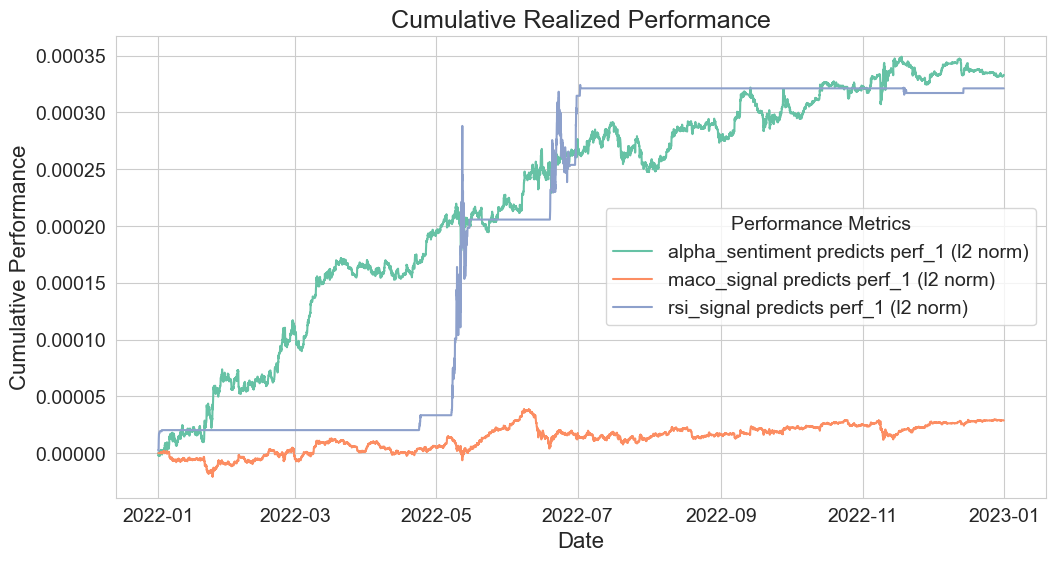

In [50]:
perfs = [c for c in plot_df.columns if "perf" in c]
signals = ["alpha_sentiment", "maco_signal", "rsi_signal"]
plot_realization(plot_df, signals, perfs, "l2", threshold=0.9)

In [52]:
for signal in signals:
    print("Metrics for", signal)
    print(compute_key_metrics(plot_df, signal, perfs))

Metrics for alpha_sentiment
{'sharpe': [2.733461981947082], 'bias': [-0.0001917852541314414], 'beta': [-0.00022225284182712774]}
Metrics for maco_signal
{'sharpe': [0.6759602110707192], 'bias': [-6.576270720388111e-05], 'beta': [-6.661798639577427e-05]}
Metrics for rsi_signal
{'sharpe': [1.6245637925919008], 'bias': [-0.00018250775067997255], 'beta': [-0.0008795466183439615]}
